**About** : This notebook is used to train models.

Ideas :
- https://www.kaggle.com/c/open-images-2019-instance-segmentation/discussion/110983

- https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/discussion/95247#latest-567841
- https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/discussion/95233#latest-551075
- https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/discussion/95234#latest-555537

- https://www.kaggle.com/c/airbus-ship-detection/discussion/71595#latest-457550
- https://www.kaggle.com/c/airbus-ship-detection/discussion/71667#latest-558876

In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src/

/home/theo/Documents/sartorius/src


## Initialization

### Imports

In [3]:
import gc
import os
import ast
import sys
import cv2
import glob
import json
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
warnings.simplefilter("ignore", UserWarning)

In [4]:
from params import *

from utils.plots import *
from utils.metrics import iou_map
from utils.logger import Config

from data.preparation import prepare_data
from data.dataset import SartoriusDataset
from data.transforms import define_pipelines

In [5]:
from utils.metrics import *
from inference.main import validate
from utils.torch import load_model_weights

## Exp

In [6]:
EXP_FOLDER = LOG_PATH + "2021-11-08/4/"
EXP_FOLDER = LOG_PATH + "2021-11-09/2/"
EXP_FOLDER = LOG_PATH + "2021-11-09/9/"

## Data

In [7]:
EXP_FOLDER

'../logs/2021-11-09/9/'

In [8]:
config = Config(json.load(open(EXP_FOLDER + "config.json", 'r')))
config.model_config = EXP_FOLDER + config.model_config.split('/')[-1]
config.data_config = EXP_FOLDER + config.data_config.split('/')[-1]

weights = sorted(glob.glob(EXP_FOLDER + "*.pt"))

In [9]:
df = prepare_data(fix=config.fix)

## Main

In [10]:
from model_zoo.models import define_model

In [11]:
def inference_val(df, config, weights):
    
    pipelines = define_pipelines(config.data_config)
    
    model = define_model(config.model_config, reduce_stride=config.reduce_stride, pretrained_weights=None)
    
    skf = StratifiedKFold(n_splits=config.k, shuffle=True, random_state=config.random_state)
    splits = list(skf.split(X=df, y=df["cell_type"]))

    all_results, dfs = [], []
    for i, (train_idx, val_idx) in enumerate(splits):
        if i in config.selected_folds:
            df_val = df.iloc[val_idx].copy().reset_index(drop=True)
            dfs.append(df_val)

            model = load_model_weights(model, weights[i])
            
            results = validate(df_val, model, config, pipelines)
            all_results += results

    return all_results, pd.concat(dfs).reset_index(drop=True)

In [12]:
results, df_oof = inference_val(df, config, weights)


 -> Loading weights from ../logs/2021-11-09/9/maskrcnn_0.pt

 -> Validation IoU mAP = 0.269


## Viz

In [13]:
pipelines = define_pipelines(config.data_config)
dataset = SartoriusDataset(df_oof, transforms=pipelines['val_viz'])

In [45]:
thresholds_conf = [0.6, 0.7, 0.95]
thresholds_mask = [0.4, 0.4, 0.4]

In [46]:
score = evaluate_results(dataset, results, thresholds_conf, thresholds_mask)
print(f'IoU mAP : {score :.4f}')

IoU mAP : 0.2930


In [47]:
%%time
score = evaluate_results(dataset, results, thresholds_conf, thresholds_mask, remove_overlap=True)
print(f'IoU mAP : {score :.4f}')

IoU mAP : 0.2899
CPU times: user 35.6 s, sys: 987 ms, total: 36.6 s
Wall time: 36.6 s


In [48]:
max_size = 1500

In [71]:
from utils.metrics import post_process_preds

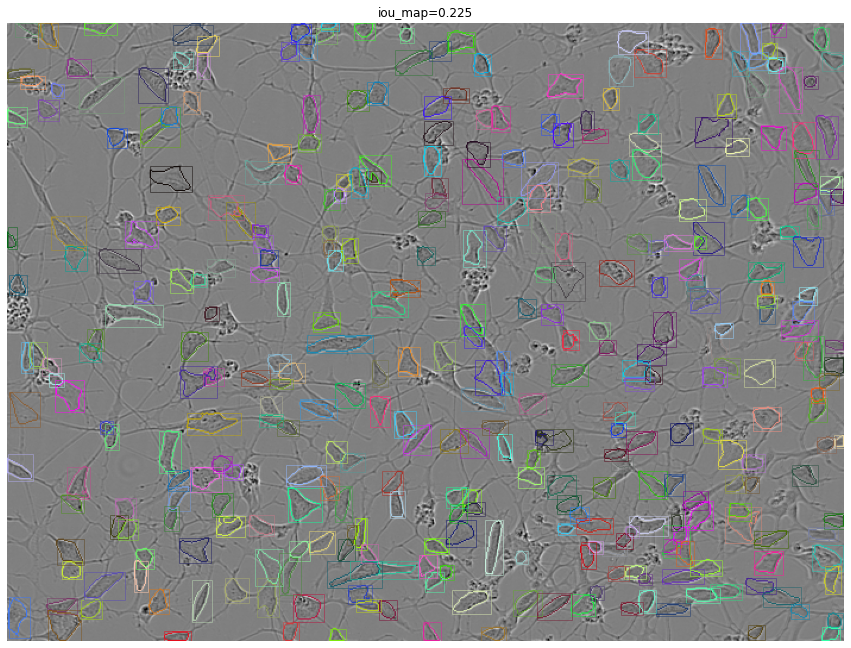

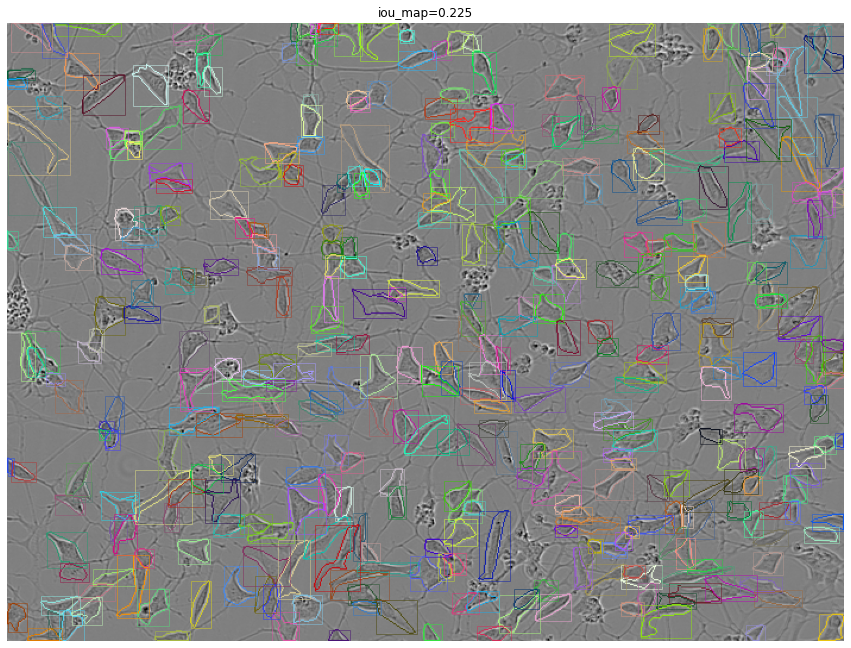

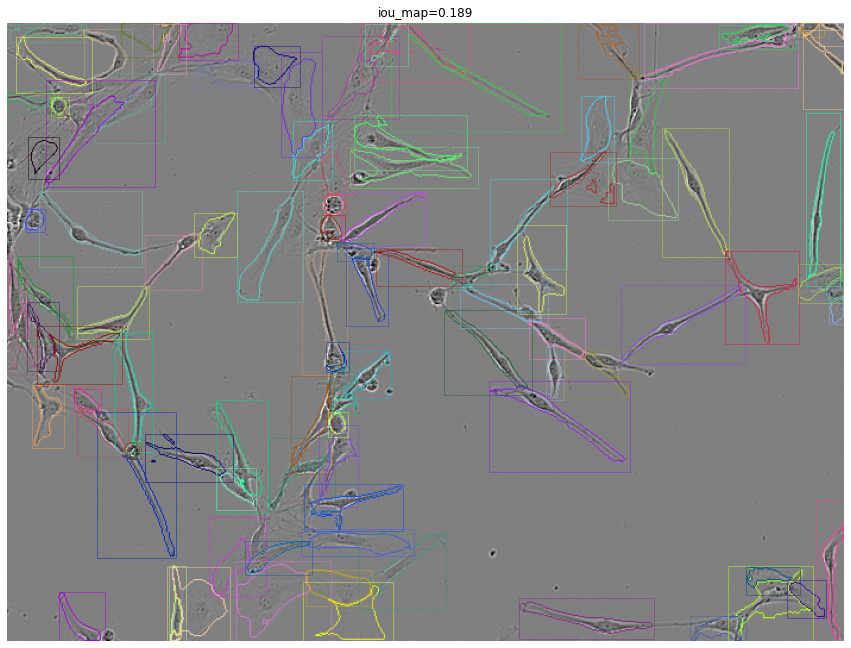

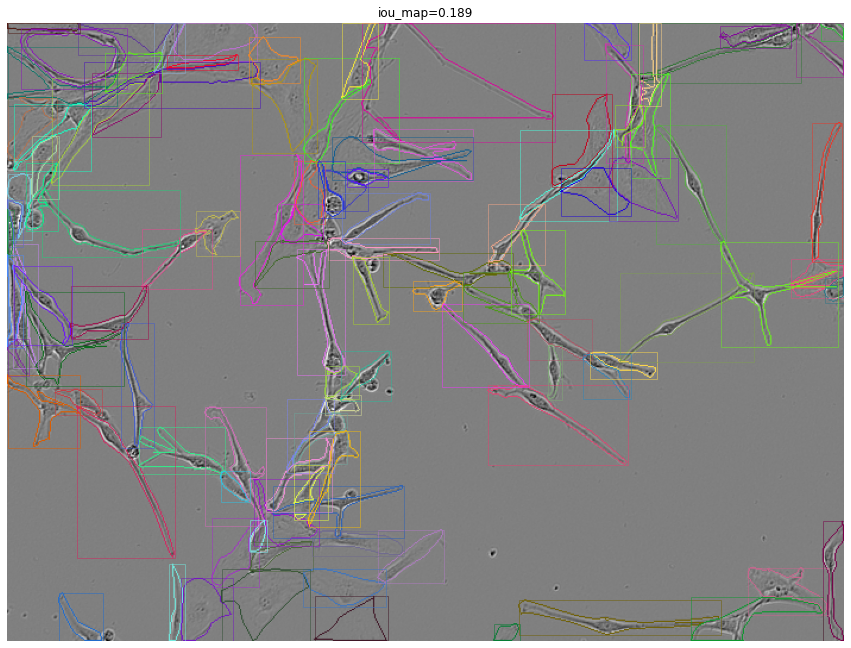

In [79]:
for idx in range(10):
    data = dataset[idx]

    img = data['img']
    truth = data['gt_masks'].masks.copy().astype(int)
    boxes_truth = data['gt_bboxes']
    
    # preds
    masks, boxes = post_process_preds(results[idx], thresholds_conf, thresholds_mask, remove_overlap=True)
    
#     sizes = np.max([boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1]], 0)
#     masks = masks[sizes < max_size]
#     boxes = boxes[sizes < max_size]
    
    # Score
    for i in range(len(truth)):
        truth[i] *= (i + 1)
    truth = truth.max(0)

    pred = masks.copy().astype(int)
    for i in range(len(pred)):
        pred[i] *= (i + 1)
    pred = pred.max(0)

    score = iou_map([truth], [pred])

    plt.figure(figsize=(15, 15))
    plot_sample(img, pred, boxes, plotly=False)
    plt.axis(False)
    plt.title(f'iou_map={score:.3f}')
    plt.show()
    
    plt.figure(figsize=(15, 15))
    plot_sample(img, truth, boxes_truth, plotly=False)
    plt.axis(False)
    plt.title(f'iou_map={score:.3f}')
    plt.show()

    if idx >= 1:
        break


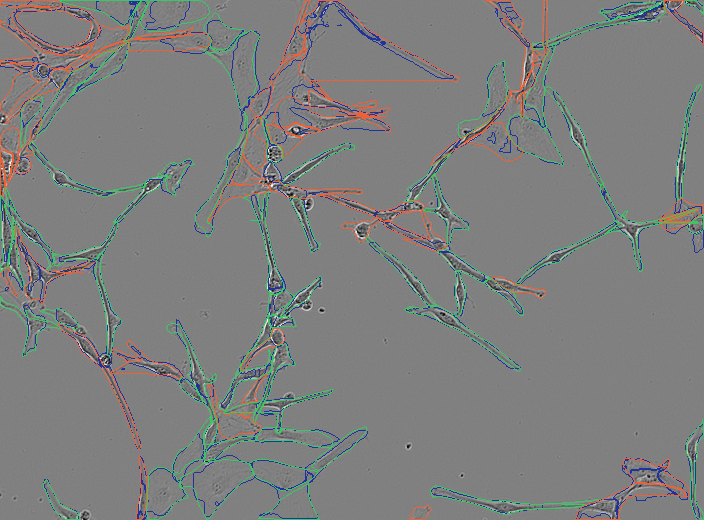

In [80]:
fig = plot_preds_iou(img, pred, truth, plot_tp=True)

fig.update_layout(
    autosize=False,
    width=900,
    height=700,
)

fig.show()